# HAR Model Notebook (Iteration 1)

## 1. Configuration
- Centralized parameters for data paths, splits, and model settings.

## 2. Data Loading
- Load and inspect raw option and volatility datasets.

## 3. Preprocessing
- Cleaning, filtering, and caching steps.

## 4. Feature Engineering
- Compute realized vol, implied vol, cross-sectional ranks, VOV.

## 5. Modeling
- Fit HAR model and meta-label Random Forest.

## 6. Evaluation
- CV, feature importance, meta-label performance.

## 7. Backtest & PnL Simulation
- Simulate trades, slippage, sizing, and reporting.

## 8. Next Steps
- Plans for further feature expansion and robust testing.


In [2]:
# === Configuration Parameters ===
# Data paths and environment
DATA_PATH = 'data/iv_data.parquet'
RESULTS_PATH = 'results/'

# Modeling parameters
TRAIN_TEST_SPLIT = 0.8
RANDOM_STATE = 42

# Meta-label thresholds
RANK_SHIFT_THRESHOLD = 2  # rank-change threshold for labeling

# Experiment settings
USE_CACHING = True
VERBOSE = True


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append("..") 
from src import load_realized_vol, build_har_features,load_earnings,load_implied_vol  # etc.
from src.load_data import load_close_to_close_realized_volatility
from src.features import fit_har_regression
from src.signals import compute_signal_matrix
from src.forecast import create_forecast
from src.signals import size_positions
from src.analytic_utils import filter_earnings,create_earnings_mask,filter_earnings_by_ticker, align_multiple


import pandas as pd
import pandas_market_calendars as mcal
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import numpy as np

In [5]:
config = {
    "har_windows": {"short": 1, "medium": 5, "long": 21},
    "forecast_horizon": 5,
    "ranking_threshold": 0.9,
    "train_test_split_ratio": 0.7,
    "train_test_gap_days": 21,
}
features_config = {
    'signal_z': True,
    'implied_z': True,
}

In [6]:
def prepare_volatility_data(config):
    realized = load_realized_vol()
    earnings = load_earnings()

    #from src.analytic_utils only keeps earnings that are within the realized volatility data
    earnings_subset = filter_earnings(
        earnings,
        realized.index.min(),
        realized.index.max()
    )
    #from src.analytic_utils only keeps earnings for the tickers that are in the realized volatility data
    earnings_subset = filter_earnings_by_ticker(earnings_subset, realized.columns)

    #from src.analytic_utils creates a mask for the earnings that are within the realized volatility data
    earnings_mask = create_earnings_mask(realized, earnings_subset)

    close_realized, future_realized = load_close_to_close_realized_volatility(
        "../data/all_vols.csv",
        realized_vol_term=config["forecast_horizon"]
    )

    implied = load_implied_vol("../output/features_data.csv", earnings_subset)

    return {
        'realized': realized,
        'earnings_mask': earnings_mask,
        'close_realized': close_realized,
        'future_realized': future_realized,
        'implied': implied
    }

def build_forecast_pipeline(realized, earnings_mask, config):
    har_windows = config["har_windows"]
    har_features = build_har_features(
        realized,
        term_1d=har_windows["short"],
        term_1w=har_windows["medium"],
        term_1m=har_windows["long"]
    )

    har_factors = fit_har_regression(
        realized,
        *(feat.shift(1) for feat in har_features),
        earnings_mask=earnings_mask
    )

    forecast = create_forecast(*har_features, har_factors)
    
    # Adjust for earnings
    realized_adjusted = realized.copy()
    realized_adjusted[earnings_mask] = forecast[earnings_mask]

    har_features_adj = build_har_features(
        realized_adjusted,
        term_1d=har_windows["short"],
        term_1w=har_windows["medium"],
        term_1m=har_windows["long"]
    )

    har_factors_adj = fit_har_regression(
        realized_adjusted,
        *(feat.shift(1) for feat in har_features_adj),
        earnings_mask=earnings_mask
    )
    forecast_final = create_forecast(*har_features_adj, har_factors_adj)
    return forecast_final

def generate_signals_and_positions(forecast, implied):
    signal_matrix = compute_signal_matrix(forecast, implied)
    positions = size_positions(signal_matrix, implied.loc[forecast.index], method='unit', threshold=0.0)
    return signal_matrix, positions

def align_data(future_realized, implied, forecast, signals, positions):
    return align_multiple(
        future_realized, implied, forecast, signals, positions,
        align_columns=True
    )


def load_and_prepare_vol_indices(aligned_dates):
    file_paths = {
        "VIX": "../data/VIX_History.csv",
        "VVIX": "../data/VVIX_History.csv",
        "VIX9D": "../data/VIX9D_History.csv"
    }

    dfs = {}
    for name, path in file_paths.items():
        df = pd.read_csv(path, parse_dates=['DATE'], index_col='DATE')
        df.rename(columns=lambda x: f"{name}_{x.strip().replace(' ', '_')}", inplace=True)
        dfs[name] = df

    vol_indices = pd.concat(dfs.values(), axis=1)[['VIX_CLOSE', 'VVIX_VVIX', 'VIX9D_CLOSE']]
    vol_indices /= 100
    vol_indices.ffill(inplace=True)

    # Align to provided dates clearly and explicitly
    aligned_vol_indices = vol_indices.reindex(aligned_dates).ffill()
    aligned_vol_indices["VIX_CLOSE_DIFF"]=aligned_vol_indices.VIX_CLOSE.diff()

    return aligned_vol_indices




# Call clearly defined pipeline functions
vol_data = prepare_volatility_data(config)
forecast = build_forecast_pipeline(vol_data['realized'], vol_data['earnings_mask'], config)
signals, positions = generate_signals_and_positions(forecast, vol_data['implied'])

aligned_realized, aligned_implied, aligned_forecast, aligned_signal, aligned_positions = align_data(
    vol_data['future_realized'], vol_data['implied'], forecast, signals, positions
)
aligned_vol_indeces=load_and_prepare_vol_indices(aligned_realized.index)

/Users/stirlitz/ncGitHub/vol_forecast/notebooks/../src/load_data.py:121: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_returns = df_prices.pct_change()


In [7]:
def split_train_test_multiple_with_validation(*dfs, train_ratio=0.6, val_ratio=0.2, train_test_gap_days=21):
    """Add validation set to your existing split function"""
    # Keep your existing logic but add validation set
    unique_dates = dfs[0].index.get_level_values(0).unique().sort_values()
    
    n_dates = len(unique_dates)
    train_end = int(n_dates * train_ratio)
    val_end = int(n_dates * (train_ratio + val_ratio))
    
    train_dates = unique_dates[:train_end]
    val_dates = unique_dates[train_end + train_test_gap_days:val_end]
    test_dates = unique_dates[val_end + train_test_gap_days:]
    
    print(f"Train: {train_dates[0]} to {train_dates[-1]} ({len(train_dates)} days)")
    print(f"Val: {val_dates[0]} to {val_dates[-1]} ({len(val_dates)} days)")  
    print(f"Test: {test_dates[0]} to {test_dates[-1]} ({len(test_dates)} days)")
    
    train_dfs, val_dfs, test_dfs = [], [], []
    
    for df in dfs:
        train_dfs.append(df[df.index.get_level_values(0).isin(train_dates)])
        val_dfs.append(df[df.index.get_level_values(0).isin(val_dates)])
        test_dfs.append(df[df.index.get_level_values(0).isin(test_dates)])
    
    return train_dfs, val_dfs, test_dfs

# 2. IMPROVE YOUR create_classifier_inputs FUNCTION:
def create_classifier_inputs_improved(forecast, implied, realized, vol_indeces=None, threshold=0.2, use_vol_indeces=False):
    """Enhanced version of your existing function with better features"""
    
    # Your existing logic
    iv_rank = implied.rank(axis=1, pct=True)
    rv_rank = realized.rank(axis=1, pct=True)
    y_binary = ((rv_rank - iv_rank) > threshold).stack().astype(int)
    
    signal = (forecast - implied).stack().rename("signal")
    
    # Align indices
    common_idx = signal.index.intersection(y_binary.index)
    signal_aligned = signal.loc[common_idx]
    y_aligned = y_binary.loc[common_idx]
    
    # Build feature dataframe
    X_df = pd.DataFrame({'signal': signal_aligned.reset_index(drop=True)})
    
    # Add signal transformations (no external dependencies)
    #X_df['signal_abs'] = X_df['signal'].abs()
    #X_df['signal_squared'] = X_df['signal'] ** 2
    #X_df['signal_rank'] = signal_aligned.groupby(level=0).rank(pct=True).reset_index(drop=True)
    
    # Add implied vol level features
    implied_aligned = implied.stack().loc[common_idx]
    X_df['implied_level'] = implied_aligned.reset_index(drop=True)
    #X_df = X_df.drop(columns=['signal'])
    #X_df['implied_rank'] = implied_aligned.groupby(level=0).rank(pct=True).reset_index(drop=True)

    if features_config.get('signal_z', False):
        forecast_aligned = forecast.stack().loc[common_idx]
        X_df['signal_z'] = signal_aligned.groupby(level=0).transform(lambda x: (x - x.mean()) / (x.std() + 1e-6)).reset_index(drop=True)

    if features_config.get('implied_z', False):
        implied_aligned = implied.stack().loc[common_idx]
        X_df['implied_z'] = implied_aligned.groupby(level=0).transform(lambda x: (x - x.mean()) / (x.std() + 1e-6)).reset_index(drop=True)
    
    # Vol indices features (your existing logic but improved)
    if use_vol_indeces and vol_indeces is not None:
        dates = common_idx.get_level_values(0)
        vol_indeces_aligned = vol_indeces.reindex(dates).reset_index(drop=True)
        
        # Add the VIX close diff you already have
        X_df['VIX_CLOSE_DIFF'] = vol_indeces_aligned.iloc[:, 3]  # Your existing feature
        
        # Add a few more vol features (no lookahead)
        vix_close = vol_indeces_aligned.iloc[:, 0]  # VIX_CLOSE
        X_df['VIX_LEVEL'] = vix_close
        X_df['VIX_HIGH'] = (vix_close > vix_close.rolling(20, min_periods=1).quantile(0.8)).astype(int)
    
    y_series = y_aligned.reset_index(drop=True)
    
    return X_df, y_series,common_idx



# 3. ADD MULTIPLE LABEL THRESHOLDS (drops right into your existing code):
def create_multiple_labels(forecast, implied, realized, thresholds=[0.1, 0.2, 0.3]):
    """Create labels with multiple thresholds for better analysis"""
    
    iv_rank = implied.rank(axis=1, pct=True)
    rv_rank = realized.rank(axis=1, pct=True)
    rank_improvement = (rv_rank - iv_rank).stack()
    
    labels_dict = {}
    for thresh in thresholds:
        labels_dict[f'label_{thresh}'] = (rank_improvement > thresh).astype(int)
    
    return pd.DataFrame(labels_dict)

# 4. ADD BUSINESS METRICS (standalone function):
def calculate_strategy_performance(positions_df, returns_df):
    """Calculate business-relevant metrics from your position matrix"""
    
    # Portfolio returns (your positions already lag by 1 day)
    portfolio_returns = (positions_df * returns_df).sum(axis=1)
    portfolio_returns = portfolio_returns.dropna()
    
    if len(portfolio_returns) == 0:
        return {"error": "No valid returns"}
    
    # Calculate metrics
    total_return = (1 + portfolio_returns).prod() - 1
    annual_return = (1 + portfolio_returns.mean()) ** 252 - 1
    annual_vol = portfolio_returns.std() * np.sqrt(252)
    sharpe = annual_return / annual_vol if annual_vol > 0 else 0
    
    # Drawdown calculation
    cumulative = (1 + portfolio_returns).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()
    
    return {
        'total_return': total_return,
        'annual_return': annual_return, 
        'annual_vol': annual_vol,
        'sharpe_ratio': sharpe,
        'max_drawdown': max_drawdown,
        'win_rate': (portfolio_returns > 0).mean(),
        'num_trades': len(portfolio_returns)
    }



# 5. IMPROVED MODEL TRAINING (drop-in replacement):
def train_model_with_validation(X_train, y_train, X_val, y_val, param_grid=None):
    """Train model with proper validation instead of using test set"""
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import roc_auc_score, classification_report
    
    if param_grid is None:
        param_grid = {
            #'max_depth': [3, 5, 7],
            'max_depth': [3],
            'n_estimators': [50, 100],
            'min_samples_split': [2, 5]
        }
    
    # Use validation set for hyperparameter tuning
    #rf = RandomForestClassifier(class_weight='balanced', random_state=42)
    
    best_score = 0
    best_model = None
    best_params = None
    
    # Manual grid search using validation set
    for max_depth in param_grid['max_depth']:
        for n_estimators in param_grid['n_estimators']:
            for min_samples_split in param_grid['min_samples_split']:
                
                model = RandomForestClassifier(
                    max_depth=max_depth,
                    n_estimators=n_estimators,
                    min_samples_split=min_samples_split,
                    class_weight='balanced',
                    random_state=42
                )
                
                model.fit(X_train, y_train)
                val_pred_proba = model.predict_proba(X_val)[:, 1]
                val_score = roc_auc_score(y_val, val_pred_proba)
                
                if val_score > best_score:
                    best_score = val_score
                    best_model = model
                    best_params = {
                        'max_depth': max_depth,
                        'n_estimators': n_estimators,
                        'min_samples_split': min_samples_split
                    }
    
    print(f"Best validation AUC: {best_score:.4f}")
    print(f"Best params: {best_params}")
    
    return best_model


# 6. QUICK DIAGNOSTIC PLOTS (standalone):
def plot_model_diagnostics(y_true, y_pred_proba, title="Model Diagnostics"):
    """Quick diagnostic plots for your model"""
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve, precision_recall_curve
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(title)
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    axes[0].plot(fpr, tpr)
    axes[0].plot([0, 1], [0, 1], 'k--')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('ROC Curve')
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    axes[1].plot(recall, precision)
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_title('Precision-Recall Curve')
    
    # Prediction Distribution by Class
    axes[2].hist(y_pred_proba[y_true == 0], alpha=0.5, label='Class 0', bins=30)
    axes[2].hist(y_pred_proba[y_true == 1], alpha=0.5, label='Class 1', bins=30)
    axes[2].set_xlabel('Predicted Probability')
    axes[2].set_ylabel('Count')
    axes[2].set_title('Prediction Distribution')
    axes[2].legend()
    
    plt.tight_layout()
    return fig


Train: 2022-02-02 00:00:00 to 2023-06-05 00:00:00 (336 days)
Val: 2023-07-07 00:00:00 to 2023-10-19 00:00:00 (74 days)
Test: 2023-11-20 00:00:00 to 2023-12-29 00:00:00 (28 days)
Best validation AUC: 0.7659
Best params: {'max_depth': 3, 'n_estimators': 100, 'min_samples_split': 2}

Feature Importance:
implied_z        0.508098
signal_z         0.350824
implied_level    0.138366
signal           0.002711
dtype: float64
✓ All improvements implemented successfully!


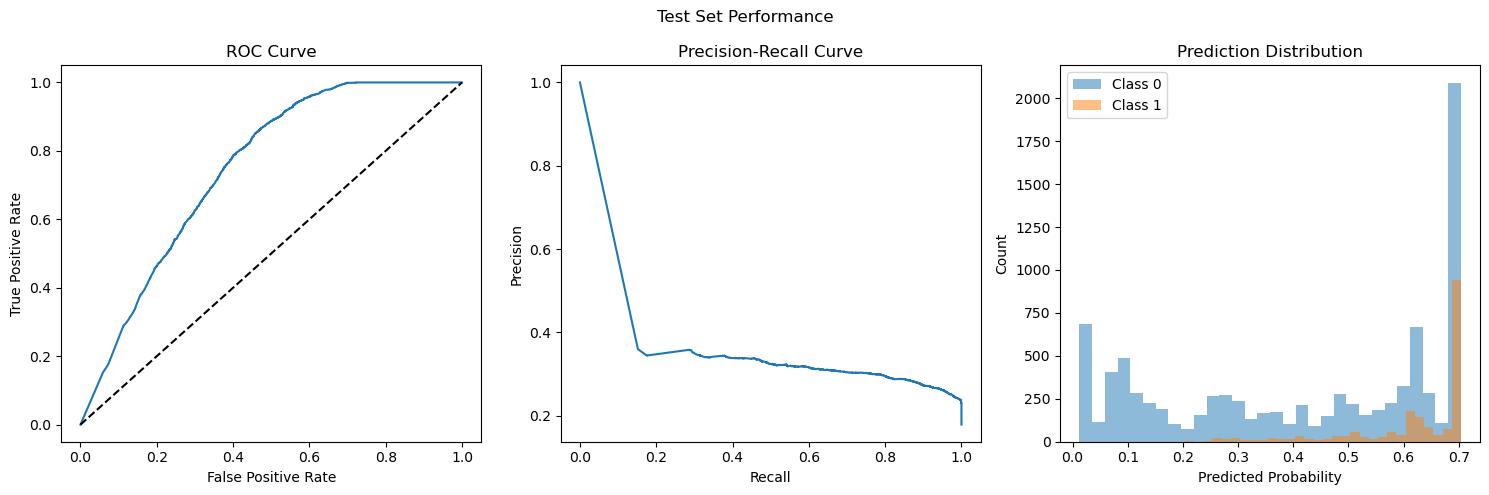

In [8]:
# STEP 1: Replace your train/test split:
train_dfs, val_dfs, test_dfs = split_train_test_multiple_with_validation(
    aligned_realized,
    aligned_implied,
    aligned_forecast,
    aligned_signal,
    aligned_positions,
    aligned_vol_indeces,  # Add this
    train_ratio=config["train_test_split_ratio"],
    train_test_gap_days=config["train_test_gap_days"]
)

# Unpack all splits
(train_realized, train_implied, train_forecast, train_signal, train_positions, train_vol_indeces) = train_dfs
(val_realized, val_implied, val_forecast, val_signal, val_positions, val_vol_indeces) = val_dfs  
(test_realized, test_implied, test_forecast, test_signal, test_positions, test_vol_indeces) = test_dfs

# STEP 2: Create features with the improved function:
X_train, y_train, train_idx = create_classifier_inputs_improved(
    train_signal, train_implied, train_realized, train_vol_indeces, use_vol_indeces=False
)

X_val, y_val, val_idx = create_classifier_inputs_improved(
    val_signal, val_implied, val_realized, val_vol_indeces, use_vol_indeces=False
)

X_test, y_test, test_idx = create_classifier_inputs_improved(
    test_signal, test_implied, test_realized, test_vol_indeces, use_vol_indeces=False
)

# STEP 3: Train model properly:
best_model = train_model_with_validation(X_train, y_train, X_val, y_val)

# STEP 4: Evaluate on test set:
test_pred_proba = best_model.predict_proba(X_test)[:, 1]
test_pred = best_model.predict(X_test)

# STEP 5: Get business metrics and diagnostics:
plot_model_diagnostics(y_test, test_pred_proba, "Test Set Performance")

# Feature importance
feature_importance = pd.Series(
    best_model.feature_importances_, 
    index=X_train.columns
).sort_values(ascending=False)
print("\nFeature Importance:")
print(feature_importance)

# STEP 6: Calculate strategy performance (if you have returns data):
# Assuming you have a returns matrix aligned with your realized vol
# strategy_metrics = calculate_strategy_performance(test_positions, test_returns)
# print(f"\nStrategy Performance: {strategy_metrics}")

print("✓ All improvements implemented successfully!")

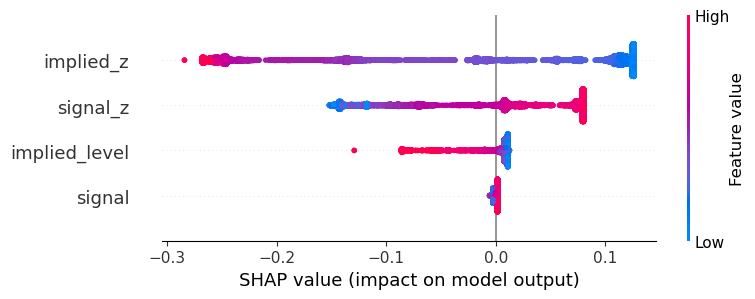

In [9]:
import  shap

explainer = shap.Explainer(best_model, X_test)
shap_values = explainer(X_test)

shap.summary_plot(shap_values[..., 1], X_test)

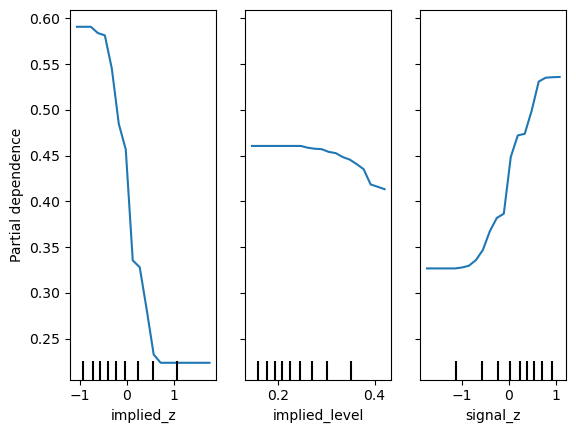

In [10]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(best_model, X_test, features=[3,1,2], grid_resolution=20)

In [11]:
def evaluate_feature_contributions(X, y, model, base_auc):
    from sklearn.metrics import roc_auc_score
    dropped_scores = {}
    for col in X.columns:
        auc_drop = roc_auc_score(y, model.fit(X.drop(columns=[col]), y).predict_proba(X.drop(columns=[col]))[:,1])
        dropped_scores[col] = base_auc - auc_drop
    return dropped_scores


evaluate_feature_contributions(X_val, y_val, best_model, 0.7659)

{'signal': np.float64(-0.00332017524774908),
 'implied_level': np.float64(-0.0026985507676176024),
 'signal_z': np.float64(-0.000259546434057345),
 'implied_z': np.float64(0.005348821570294149)}

In [12]:
def compute_vol_pnl_proxy(y_proba, implied, realized, data_idx, upper=0.6, lower=0.3):
    """
    Inputs:
        y_proba: predicted probability that RV > IV
        implied: aligned implied vol series
        realized: aligned realized vol series
    Returns:
        DataFrame with trades and PnLs
    """
    trades = pd.DataFrame({
        'ticker': data_idx.get_level_values(1),
        'date': data_idx.get_level_values(0),
        'proba': y_proba,
        'implied': implied,
        'realized': realized
    }).dropna()

    # Long vol: Buy where prob > upper
    trades['position'] = 0
    trades.loc[trades['proba'] > upper, 'position'] = 1
    trades.loc[trades['proba'] < lower, 'position'] = -1

    # Normalize weights to have same size long and short exposure
    long_count = (trades['position'] == 1).sum()
    short_count = (trades['position'] == -1).sum()

    if long_count and short_count:
        trades.loc[trades['position'] == 1, 'weight'] = 1 / long_count
        trades.loc[trades['position'] == -1, 'weight'] = 1 / short_count
    else:
        trades['weight'] = 0

    # Compute trade PnL: (RV - IV) for long, (IV - RV) for short
    trades['pnl'] = trades['position'] * (trades['realized'] - trades['implied']) * trades['weight']

    return trades




In [13]:
def evaluate_pnl_contribution(X, y, base_model, base_trades, implied, realized, common_idx):
    from sklearn.base import clone
    pnl_drop = {}
    base_pnl = base_trades['pnl'].sum()

    for col in X.columns:
        X_sub = X.drop(columns=[col])
        model = clone(base_model).fit(X_sub, y)
        y_proba = model.predict_proba(X_sub)[:, 1]

        trades = compute_vol_pnl_proxy(
            y_proba=y_proba,
            implied=implied,
            realized=realized,
            data_idx=common_idx
        )

        pnl_drop[col] = base_pnl - trades['pnl'].sum()

    return pnl_drop

In [14]:
evaluate_pnl_contribution(X_val, y_val, best_model, trades, implied_series, realized_series, val_idx)

NameError: name 'trades' is not defined

In [107]:
test_pred_proba
implied_series


0        0.319443
1        0.425320
2        0.152162
3        0.154063
4        0.161635
           ...   
11015    0.202809
11016    0.214562
11017    0.279585
11018    0.353242
11019    0.195681
Length: 11020, dtype: float64

In [148]:
#test_idx = test_implied.index
implied_series = test_implied.stack(future_stack=True).loc[test_idx].reset_index(drop=True)
realized_series = test_realized.stack(future_stack=True).loc[test_idx].reset_index(drop=True)
trades = compute_vol_pnl_proxy(test_pred_proba, implied_series, realized_series, test_idx)

In [127]:
test_idx.get_level_values(0)

DatetimeIndex(['2023-11-20', '2023-11-20', '2023-11-20', '2023-11-20',
               '2023-11-20', '2023-11-20', '2023-11-20', '2023-11-20',
               '2023-11-20', '2023-11-20',
               ...
               '2023-12-29', '2023-12-29', '2023-12-29', '2023-12-29',
               '2023-12-29', '2023-12-29', '2023-12-29', '2023-12-29',
               '2023-12-29', '2023-12-29'],
              dtype='datetime64[ns]', length=11020, freq=None)

total_pnl: 0.0205
avg_pnl: 0.0000
win_rate: 0.3652
n_trades: 6683.0000
n_long: 3892.0000
n_short: 2791.0000
long_pnl: -0.0129
short_pnl: 0.0334


<Axes: title={'center': 'Cumulative Proxy PnL Over Time'}, xlabel='date'>

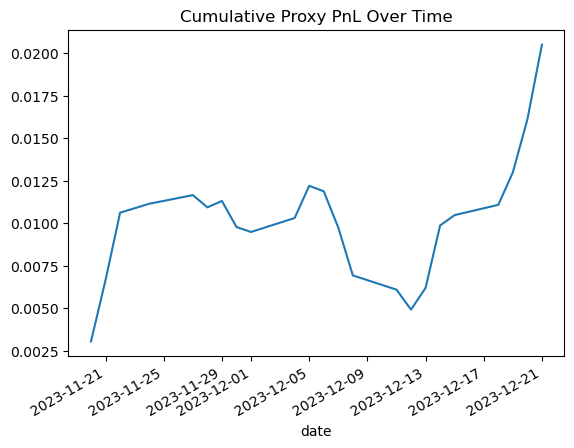

In [150]:
def summarize_vol_proxy(trades):
    """
    Summarizes key metrics from the proxy PnL DataFrame returned by compute_vol_pnl_proxy.
    """
    summary = {}

    if trades.empty or trades['position'].abs().sum() == 0:
        return {
            'total_pnl': 0,
            'avg_pnl': 0,
            'win_rate': 0,
            'n_trades': 0,
            'n_long': 0,
            'n_short': 0,
            'long_pnl': 0,
            'short_pnl': 0,
        }

    total_pnl = trades['pnl'].sum()
    avg_pnl = trades['pnl'].mean()
    win_rate = (trades['pnl'] > 0).mean()
    n_trades = trades['position'].abs().sum()
    n_long = (trades['position'] == 1).sum()
    n_short = (trades['position'] == -1).sum()

    long_pnl = trades.loc[trades['position'] == 1, 'pnl'].sum()
    short_pnl = trades.loc[trades['position'] == -1, 'pnl'].sum()

    summary.update({
        'total_pnl': total_pnl,
        'avg_pnl': avg_pnl,
        'win_rate': win_rate,
        'n_trades': n_trades,
        'n_long': n_long,
        'n_short': n_short,
        'long_pnl': long_pnl,
        'short_pnl': short_pnl,
    })

    return summary

#trades = compute_vol_pnl_proxy(...)
summary = summarize_vol_proxy(trades)
for k, v in summary.items():
    print(f"{k}: {v:.4f}")

pnl_over_time = trades.groupby('date')['pnl'].sum()
pnl_over_time.cumsum().plot(title='Cumulative Proxy PnL Over Time')

In [57]:
import matplotlib.pyplot as plt

def explore_trades(trades):
    if trades.empty:
        print("No trades to analyze.")
        return

    # Summary stats
    print(f"Total PnL: {trades['pnl'].sum():.4f}")
    print(f"Avg PnL: {trades['pnl'].mean():.4f}")
    print(f"Win rate: {(trades['pnl'] > 0).mean():.2%}")
    print(f"Trades: long={sum(trades['position']==1)}, short={sum(trades['position']==-1)}")

    # PnL over time
    pnl_time = trades.groupby('date')['pnl'].sum().cumsum()
    plt.figure(figsize=(10, 4))
    pnl_time.plot(title="Cumulative Proxy PnL Over Time")
    plt.axhline(0, linestyle='--', color='gray')
    plt.ylabel("Cumulative PnL")
    plt.grid(True)
    plt.show()

    # Top and bottom tickers
    pnl_by_ticker = trades.groupby('ticker')['pnl'].sum().sort_values()
    print("\n🔻 Bottom 5 tickers:")
    print(pnl_by_ticker.head(5))
    print("\n🚀 Top 5 tickers:")
    print(pnl_by_ticker.tail(5))

    # Weird data probe
    weird = trades[
        (trades['implied'] > 2.0) | 
        (trades['realized'] > 2.0) | 
        (trades['realized'] < 0.01)
    ]
    if not weird.empty:
        print(f"\n⚠️ Weird data rows: {len(weird)}")
        display(weird[['date', 'ticker', 'implied', 'realized', 'pnl']].head())

Total PnL: 0.0205
Avg PnL: 0.0000
Win rate: 36.52%
Trades: long=3892, short=2791


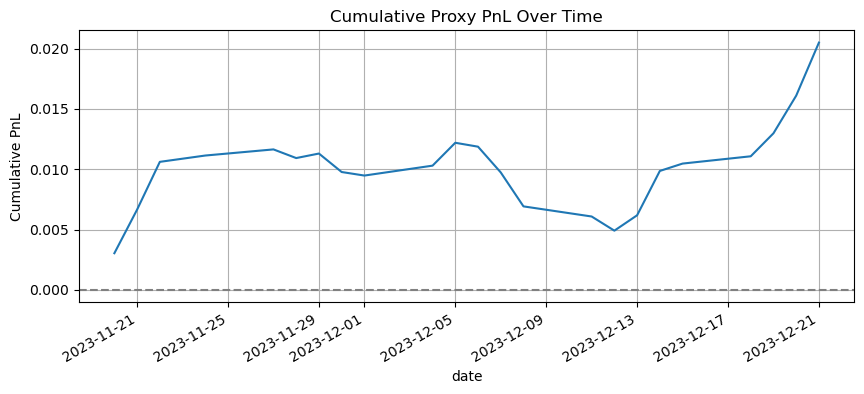


🔻 Bottom 5 tickers:
ticker
BXP    -0.001086
ZION   -0.000924
VFC    -0.000798
VRTX   -0.000743
ILMN   -0.000725
Name: pnl, dtype: float64

🚀 Top 5 tickers:
ticker
RMD     0.000916
APA     0.000939
DISH    0.001033
TSLA    0.001054
CPT     0.001614
Name: pnl, dtype: float64


In [151]:
explore_trades(trades)

In [40]:
# Assume common_idx is still available and matches test_pred_proba
dates = test_idx.get_level_values(0).to_list()
#strikes = ctest_idx.get_level_values(1).to_list()
dates
#trades['date'] = dates
#trades['strike'] = strikes
trades

,proba,implied,realized,position,weight,pnl
0,0.106016,0.319443,0.189485,-1,0.000371,0.000048
1,0.017330,0.425320,0.462744,-1,0.000371,-0.000014
2,0.689810,0.152162,0.067721,0,NaN,NaN
3,0.702621,0.154063,0.062145,1,0.000574,-0.000053
4,0.703088,0.161635,0.087704,1,0.000574,-0.000042
...,...,...,...,...,...,...
8853,0.703948,0.183974,0.098413,1,0.000574,-0.000049
8854,0.483148,0.217606,0.083746,0,NaN,NaN
8855,0.233286,0.301901,0.203706,-1,0.000371,0.000036
8856,0.022232,0.408206,0.205506,-1,0.000371,0.000075


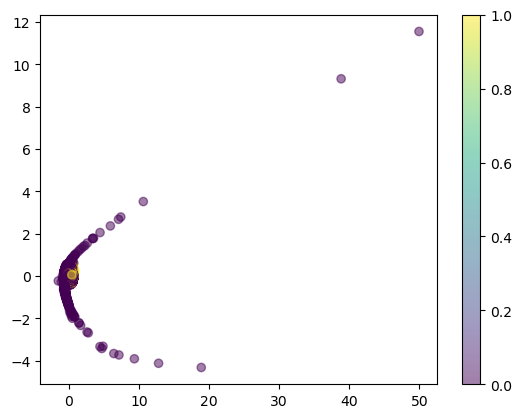

In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X_train)
plt.scatter(X_reduced[:, 1], X_reduced[:, 2], c=y_train, alpha=0.5)
plt.colorbar()
plt.show()

In [22]:
# Print summary statistics for key variables
print("\nShape of aligned data:")
print(f"Realized volatility: {aligned_realized.shape}")
print(f"Implied volatility: {aligned_implied.shape}") 
print(f"Forecast: {aligned_forecast.shape}")
print(f"Signals: {aligned_signal.shape}")
print(f"Positions: {aligned_positions.shape}")

print("\nDate ranges:")
print(f"Start date: {aligned_realized.index[0]}")
print(f"End date: {aligned_realized.index[-1]}")

print("\nNumber of tickers:", len(aligned_realized.columns))

print("\nSample of tickers:", list(aligned_realized.columns[:5]))

# Display first few rows of realized vol to see the data structure
print("\nSample of realized volatility data:")
print(aligned_realized.iloc[:5, :5])



Shape of aligned data:
Realized volatility: (480, 500)
Implied volatility: (480, 500)
Forecast: (480, 500)
Signals: (480, 500)
Positions: (480, 500)

Date ranges:
Start date: 2022-02-02 00:00:00
End date: 2023-12-29 00:00:00

Number of tickers: 500

Sample of tickers: ['A', 'AAL', 'AAP', 'AAPL', 'ABBV']

Sample of realized volatility data:
ticker             A       AAL       AAP      AAPL      ABBV
2022-02-02  0.226367  0.595173  0.261558  0.185782  0.151760
2022-02-03  0.235725  0.574931  0.374366  0.217290  0.108449
2022-02-04  0.319787  0.708597  0.334509  0.267952  0.114484
2022-02-07  0.333927  0.616985  0.334969  0.268398  0.087186
2022-02-08  0.335015  0.743582  0.310487  0.281488  0.108720
